# Setup

In [10]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s /content/drive/MyDrive/aml-assignments/assignment-2/ assignment-2

Mounted at /content/drive


# Imports


In [1]:
!pip install torchinfo

In [2]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchinfo import summary

In [4]:
# utility imports
import os
from tqdm import tqdm
import pickle

In [5]:
import warnings

warnings.filterwarnings("ignore")

# Configuration


In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
SAMPLE_SIZE = 16
NUM_FEATURES_GEN = 8
NUM_FEATURES_DISC = 4
NUM_CHANNELS = 1
Z_DIM = 16

EPOCHS = 10
GRAD_NORM_CLIP = 1
LEARNING_RATE = 2e-4
BETA = (0.5, 0.999)

In [8]:
def modelsummary(model, input_size):
    print(
        summary(
            model,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params"],
        )
    )

# Dataset


In [9]:
class MnistDataset(Dataset):
    def __init__(self, img_file: str, transform=None, device: str = DEVICE):
        super().__init__()
        self.images = pd.read_csv(img_file)
        self.labels = self.images["label"]
        self.images.drop(columns=["label"], inplace=True)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = torch.tensor(self.images.iloc[index, :]).view((1, 28, 28)).float() / 255
        img = (img * 2) - 1
        if self.transform:
            img = self.transform(img)
        img = img.to(self.device)
        return img, self.labels[index]

    def show(self, index):
        img = torch.tensor(self.images.loc[index, :]).view((28, 28)).float()
        label = self.labels[index]
        plt.imshow(img, cmap="gray")
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(f"Label: {label}")
        plt.tight_layout()
        plt.show()

In [11]:
data = MnistDataset("assignment-2/data/mnist/mnist_test.csv")

# GAN


## Generator


In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_channels, num_features_gen) -> None:
        super().__init__()

        # dimensions
        self.latent_dim = z_dim
        self.num_channels = num_channels
        self.num_features_gen = num_features_gen

        # layers
        self.fc = nn.Linear(z_dim, num_features_gen * 64)
        self.conv1 = self._deconv_block(
            num_features_gen * 4, num_features_gen * 2, 4, 1, 0, use_batchnorm=True
        )
        self.conv2 = self._deconv_block(
            num_features_gen * 2, num_features_gen, 4, 2, 1, use_batchnorm=True
        )
        self.conv3 = self._deconv_block(
            num_features_gen, num_channels, 4, 2, 1, use_batchnorm=False
        )
        self.tanh = nn.Tanh()

    def _deconv_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        use_batchnorm: bool,
    ) -> nn.Sequential:
        modules = []
        bias = True if not use_batchnorm else False
        modules.append(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        )
        if use_batchnorm:
            modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
        modules.append(nn.Dropout(0.3))
        return nn.Sequential(*modules)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.num_features_gen * 4, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.tanh(x)  # images are normalised to have pixels within -1, 1
        return x


model = Generator(Z_DIM, NUM_CHANNELS, NUM_FEATURES_GEN)
modelsummary(model, (BATCH_SIZE, Z_DIM))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Generator                                [32, 16]                  [32, 1, 28, 28]           --
├─Linear: 1-1                            [32, 16]                  [32, 512]                 8,704
├─Sequential: 1-2                        [32, 32, 4, 4]            [32, 16, 7, 7]            --
│    └─ConvTranspose2d: 2-1              [32, 32, 4, 4]            [32, 16, 7, 7]            8,192
│    └─BatchNorm2d: 2-2                  [32, 16, 7, 7]            [32, 16, 7, 7]            32
│    └─ReLU: 2-3                         [32, 16, 7, 7]            [32, 16, 7, 7]            --
│    └─Dropout: 2-4                      [32, 16, 7, 7]            [32, 16, 7, 7]            --
├─Sequential: 1-3                        [32, 16, 7, 7]            [32, 8, 14, 14]           --
│    └─ConvTranspose2d: 2-5              [32, 16, 7, 7]            [32, 8, 14, 14]           2,048
│    └─BatchNorm2d: 2-6   

## Discriminator


In [13]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, num_features_disc) -> None:
        super().__init__()
        self.conv1 = self._conv_block(
            num_channels, num_features_disc * 4, 4, 2, 1, use_batchnorm=False
        )
        self.conv2 = self._conv_block(
            num_features_disc * 4, num_features_disc * 8, 4, 2, 1, use_batchnorm=True
        )
        self.conv3 = self._conv_block(
            num_features_disc * 8, num_features_disc * 16, 4, 2, 1, use_batchnorm=True
        )
        self.fc = nn.Linear(576, 1)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def _conv_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        use_batchnorm: bool,
    ) -> nn.Sequential:
        modules = []
        bias = True if not use_batchnorm else False
        modules.append(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        )
        if use_batchnorm:
            modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.LeakyReLU(0.2))
        modules.append(nn.Dropout(0.3))
        return nn.Sequential(*modules)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        probs = self.sigmoid(x)
        return probs


model = Discriminator(NUM_CHANNELS, NUM_FEATURES_DISC)
modelsummary(model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Discriminator                            [32, 1, 28, 28]           [32, 1]                   --
├─Sequential: 1-1                        [32, 1, 28, 28]           [32, 16, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 1, 28, 28]           [32, 16, 14, 14]          272
│    └─LeakyReLU: 2-2                    [32, 16, 14, 14]          [32, 16, 14, 14]          --
│    └─Dropout: 2-3                      [32, 16, 14, 14]          [32, 16, 14, 14]          --
├─Sequential: 1-2                        [32, 16, 14, 14]          [32, 32, 7, 7]            --
│    └─Conv2d: 2-4                       [32, 16, 14, 14]          [32, 32, 7, 7]            8,192
│    └─BatchNorm2d: 2-5                  [32, 32, 7, 7]            [32, 32, 7, 7]            64
│    └─LeakyReLU: 2-6                    [32, 32, 7, 7]            [32, 32, 7, 7]            --
│    └─Dropout: 2-7            

## Weights initialisation

initialising the weights to $\mathbb{N}(0, 0.02^2)$


In [14]:
def weights_initialisation(model):
    for m in model.modules():
        classname = m.__class__.__name__
        if (
            classname.find("Conv") != -1
            or classname.find("Linear") != -1
            or classname.find("BatchNorm") != -1
        ):
            nn.init.normal_(m.weight.data, 0.0, 0.2)

        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

# Training


In [21]:
def visualise(samples_per_epoch):
    samples = samples_per_epoch.cpu()
    fig, axs = plt.subplots(2, 8)
    rows = [samples[:8], samples[8:]]
    for i, ax in enumerate(axs):
        for j, a in enumerate(ax):
            a.imshow(rows[i][j].view(28, 28).data)
            a.set_xticks([], [])
            a.set_yticks([], [])
    plt.tight_layout()
    plt.show()

In [25]:
def train_one_epoch(
    epoch, gen, disc, train_dataloader, optimiser_gen, optimiser_disc, loss_fn
):
    loop = tqdm(train_dataloader, unit=" batch")
    losses = []
    for i, (real, _) in enumerate(loop):
        loop.set_description_str(f"Epoch = {epoch}")

        # forward pass
        real = real.to(DEVICE)
        noise = (
            torch.distributions.uniform.Uniform(-1, 1)
            .sample([BATCH_SIZE, Z_DIM])
            .to(DEVICE)
        )
        fake = gen(noise)

        # train discriminator
        disc_out_real = disc(real).reshape(-1)
        loss_disc_real = loss_fn(disc_out_real, torch.ones_like(disc_out_real))

        disc_out_fake = disc(fake).reshape(-1)
        loss_disc_fake = loss_fn(disc_out_fake, torch.zeros_like(disc_out_fake))

        loss_disc = (loss_disc_fake + loss_disc_real) / 2
        disc.zero_grad(set_to_none=True)
        loss_disc.backward(retain_graph=True)
        optimiser_disc.step()

        # train generator
        out = disc(fake).reshape(-1)
        loss_gen = loss_fn(out, torch.ones_like(out))
        gen.zero_grad(set_to_none=True)
        loss_gen.backward()
        optimiser_gen.step()

        losses.append([loss_disc.cpu().item(), loss_gen.cpu().item()])

        if i % 10 == 0:
            loop.set_postfix_str(
                f"Discriminator Loss = {loss_disc.item(): .3f} | Generator Loss = {loss_gen.item(): .3f}"
            )
    return losses


def train(
    gen,
    disc,
    train_dataloader,
    optimiser_gen,
    optimiser_disc,
    loss_fn,
    fixed_z,
):
    samples = []
    losses = []
    for epoch in range(EPOCHS):
        model.train()
        losses_per_epoch = train_one_epoch(
            epoch + 1,
            gen,
            disc,
            train_dataloader,
            optimiser_gen,
            optimiser_disc,
            loss_fn,
        )

        gen.eval()
        samples_per_epoch = generate(gen, fixed_z)

        visualise(samples_per_epoch)

        samples.append(samples_per_epoch)
        losses.extend(losses_per_epoch)

    with open("assignment-2/saved-model/train_samples.pkl", "wb") as f:
        pickle.dump(samples, f)


def generate(gen, fixed_z):
    return gen(fixed_z)

In [23]:
def save_model(model, name):
    torch.save(model.state_dict(), f"assignment-2/saved-model/gan-{name}.pth")


def load_model(model, name):
    model.load_state_dict(torch.load(f"assignment-2/saved-model/gan-{name}.pth"))


def train_network(
    gen: nn.Module,
    disc: nn.Module,
    train_dataloader: DataLoader,
    name: str,
):
    weights_initialisation(gen)
    weights_initialisation(disc)
    optimiser_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=BETA)
    optimiser_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=BETA)
    loss_fn = nn.BCELoss()
    fixed_z = (
        torch.distributions.uniform.Uniform(-1, 1)
        .sample([SAMPLE_SIZE, Z_DIM])
        .to(DEVICE)
    )

    losses = train(
        gen,
        disc,
        train_dataloader,
        optimiser_gen,
        optimiser_disc,
        loss_fn,
        fixed_z,
    )
    save_model(model, name)
    return losses

In [19]:
train_dataset = MnistDataset("assignment-2/data/mnist/mnist_train.csv")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch = 1: 100%|██████████| 1875/1875 [02:40<00:00, 11.68 batch/s, Discriminator Loss =  0.001 | Generator Loss =  7.596]


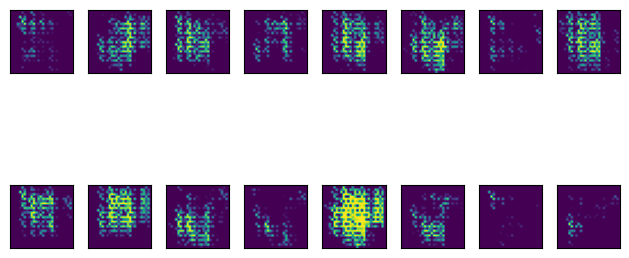

Epoch = 2:  96%|█████████▋| 1806/1875 [02:35<00:05, 13.16 batch/s, Discriminator Loss =  0.000 | Generator Loss =  9.053]

In [ ]:
disc = Discriminator(NUM_CHANNELS, NUM_FEATURES_DISC).to(DEVICE)
gen = Generator(Z_DIM, NUM_CHANNELS, NUM_FEATURES_GEN).to(DEVICE)
train_network(gen, disc, train_dataloader, "trial-1")